In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

In [46]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
# Setup your PBSCluster

project = 'P93300641' #input your project code

cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='25GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project=project, # Input your project ID here
    walltime='00:15:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(25)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/trendy-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40463 instead
  f"Port {expected} is already in use.\n"


In [47]:
client.cluster

In [48]:
dvs=['TOTVEGC','TOTECOSYSC','GPP','NPP','TOTSOMC','TWS']
d='/glade/scratch/djk2120/archive/TRENDY2022_f09_spinPostAD/lnd/hist/'
f1=sorted(glob.glob(d+'*h0*nc'))
f2=[]
#d='/glade/scratch/djk2120/TRENDY2022_f09_spinPostAD/run/'
#f2=sorted(glob.glob(d+'*spinPostAD.clm2.h0.*'))[:-1]

In [49]:
def preprocess(ds):
    return ds[dvs]
ds=xr.open_mfdataset([*f1,*f2],combine='nested',concat_dim='time',parallel=True,preprocess=preprocess)

In [50]:
tmp = xr.open_dataset(f1[0])
la = tmp.area*tmp.landfrac

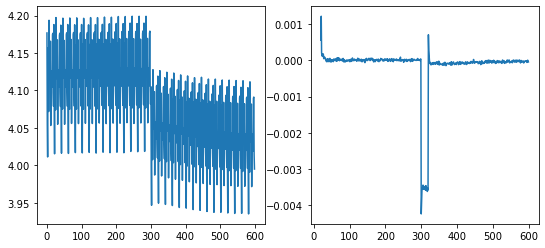

In [51]:
v='NPP'
cf=1e-9*24*60*60*30
nt = len(ds.time)
ix = np.arange(nt)>0
x=cf*(la*ds[v]).isel(time=ix).sum(dim=['lat','lon']).compute()
plt.figure(figsize=[9,4])
plt.subplot(121)
plt.plot(x)
plt.subplot(122)
plt.plot(20+np.arange(nt-21),(x[20:].values-x[:-20].values)/20)
#plt.xlim([300,400])

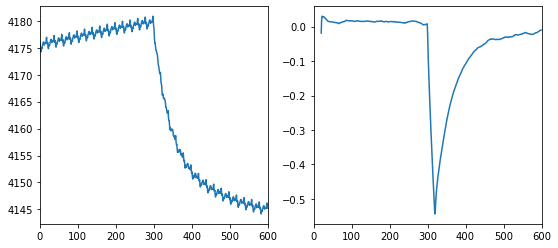

In [52]:
v='TOTECOSYSC'
nt = len(ds.time)
ix = np.arange(nt)>0

#cf=1e-9*24*60*60*30
cf=1e-9
x=cf*(la*ds[v]).isel(time=ix).sum(dim=['lat','lon']).compute()

plt.figure(figsize=[9,4])
plt.subplot(121)
plt.plot(x)
plt.xlim([0,nt])
plt.subplot(122)
plt.plot(20+np.arange(nt-21),(x[20:].values-x[:-20].values)/20)

plt.xlim([0,nt]);

In [53]:
drift = np.mean(x[-40:-20].values-x[-20:].values)/20
drift

0.015391846001148225

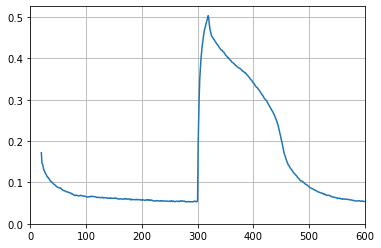

In [54]:
cf=1
x=cf*ds[v][1:,:,:]
nt = len(x)-20
x1=x.shift(time=20)[20:,:,:]
x2=x[20:,:,:]
diseq=(la*(abs(x2-x1)>20)).sum(dim=['lat','lon'])/la.sum()
plt.plot(20+np.arange(nt),diseq)
plt.xlim([0,600])
plt.ylim(bottom=0)
plt.grid()

In [55]:
diseq[-1].values

array(0.05411467, dtype=float32)

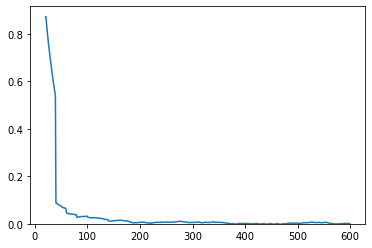

In [34]:
v='TOTVEGC'
nt = len(ds.time)
ix = np.arange(nt)>0

cf=1e-9
x=cf*(la*ds[v]).isel(time=ix).sum(dim=['lat','lon']).compute()
plt.plot(20+np.arange(nt-21),(x[20:].values-x[:-20].values)/20)
plt.ylim(bottom=0);

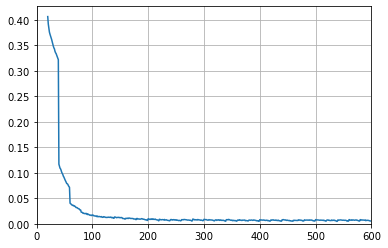

In [36]:
cf=1
x=cf*ds[v][1:,:,:]
nt = len(x)-20
x1=x.shift(time=20)[20:,:,:]
x2=x[20:,:,:]
diseq=(la*(abs(x2-x1)>60)).sum(dim=['lat','lon'])/la.sum()
plt.plot(20+np.arange(nt),diseq)
plt.xlim([0,600])
plt.ylim(bottom=0)
plt.grid()